# Load Data 

Returns from FX investments (for a US investor) in percent are in `Data_Returns.csv` (extract the returns into a matrix `R`) and log forward premia in percent are in `Data_Forwardpremia.csv` (extract the forward premia into a matrix `fp`). Convert the first columns to Julia dates.

Test if the dates in the two files are the same.

The currency names/abbreviations are
`["AUD","CAD","EUR","JPY","NZD","NOK","SEK","CHF","GBP"]` 

In [14]:
using DelimitedFiles, Printf, Dates, Plots, Statistics

include("jlFiles/printmat.jl")
gr(size=(480,320))
default(fmt = :svg)

In [15]:
# Load data
R = readdlm("Data/Data_Returns.csv",',',skipstart=1) 
fp = readdlm("Data/Data_Forwardpremia.csv",',',skipstart=2)          

# Convert to julia dates
R[:,1] .= Date.(R[:,1])
fp[:,1] .= Date.(fp[:,1])

# Check if all dates are the same
if all(fp[:,1] .== R[:,1])
    print("All dates are the same")
else 
    print("Some dates are different")
end


All dates are the same

# Plot the forward premia

against time. Create a figure with 3x3 subplots. In the plot show the forward premia multiplied by 12 so they can be interpreted as the (annualised) interest rate differential (foreign minus US). 

Make sure to 
1. have tick marks on the x-axis at `[Date(2000),Date(2010),Date(2020)]`

2. limit the y-axis to `(-6,6)`

3. Put the currency name/abbreviation in the title of each subfigure.

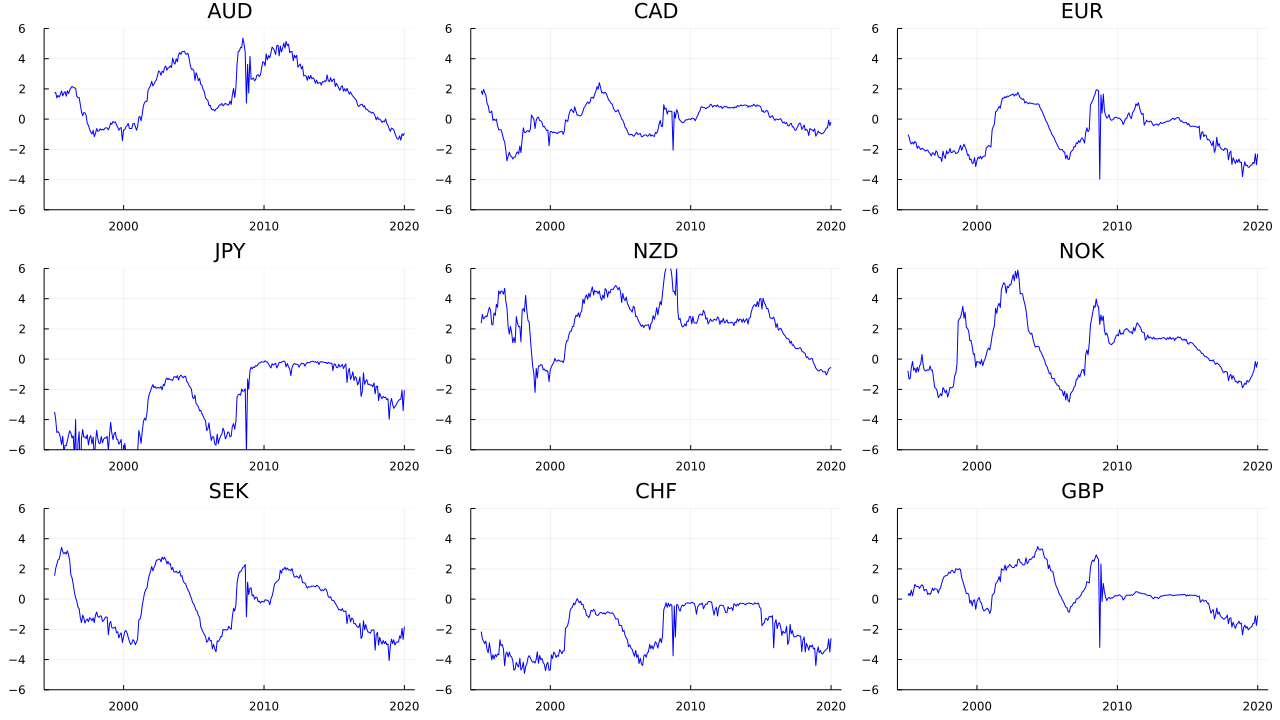

In [16]:
# Dates
dates = fp[:,1]

# Function to create the Plots
function getForwardPremiaPlot(y, title)
    return plot(dates, y .* 12, 
                size = (1280, 720),
                ylim = (-6, 6),
                xticks = ([Date(2000),Date(2010),Date(2020)], ["2000","2010","2020"]),
                legend = false,
                title = title,
                color = "blue",
            )
end

# Create plot with 3x3 subplots 
plot(getForwardPremiaPlot(fp[:,2], "AUD"), getForwardPremiaPlot(fp[:,3], "CAD"), getForwardPremiaPlot(fp[:,4], "EUR"),
getForwardPremiaPlot(fp[:,5], "JPY"),getForwardPremiaPlot(fp[:,6], "NZD"),getForwardPremiaPlot(fp[:,7], "NOK"),
getForwardPremiaPlot(fp[:,8], "SEK"),getForwardPremiaPlot(fp[:,9], "CHF"),getForwardPremiaPlot(fp[:,10], "GBP"))

# Plot cumulated log returns

in a 3x3 figure (similar to before). The cumulated log returns for a given currency are $r_1,r_1+r_2,r_1+r_2+r_3,...$ etc where $r_t$ is the log return in period $t$.

Make sure to
1. use the same tick marks on the x-axis as before
2. limit the y-axis to (-1,1)

Hints:
1. log returns are $r= \ln(1+R/100)$ since the returns in `R` are in percent. In Julia, use `log()` for the natural logarithm.
2. cumulate using `cumsum()` or by a loop so you get a $T \times 9$ matrix.

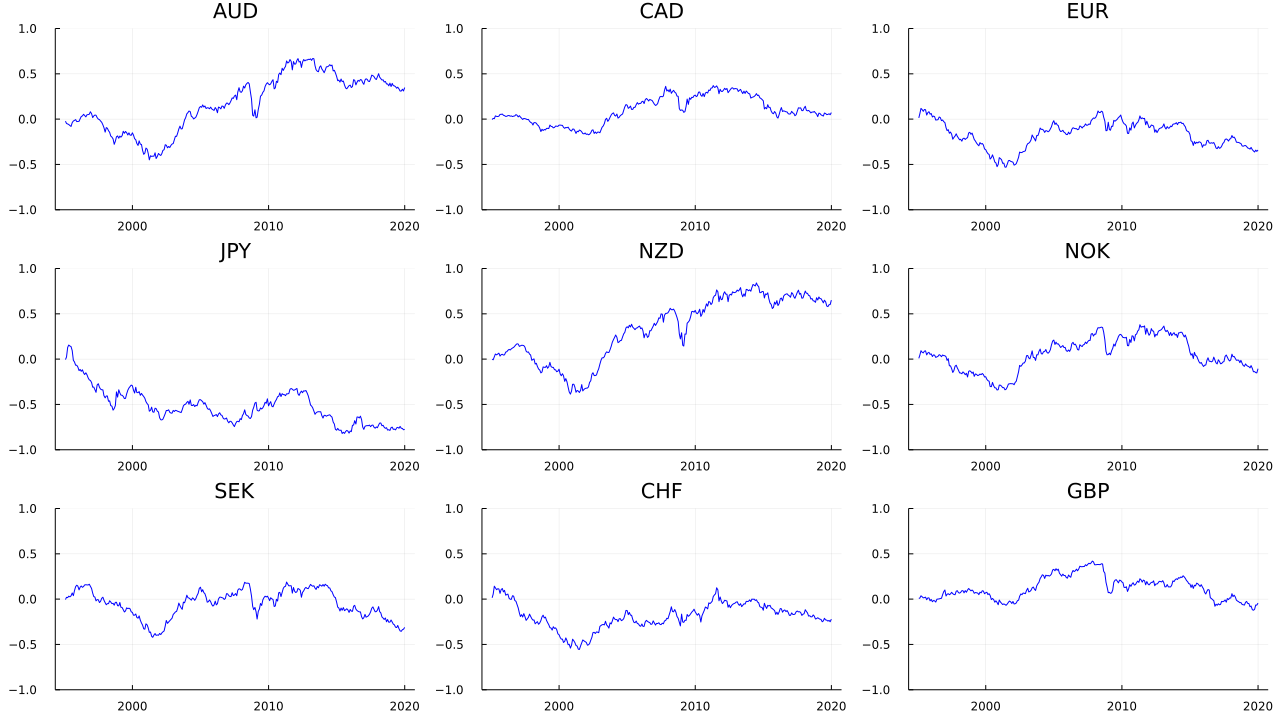

In [17]:
# Function to create the Plots
function getCumulatedLogReturnsPlot(y, title)
    return plot(dates, cumsum(log.(1 .+ y./100)), 
                size = (1280, 720),
                ylim = (-1, 1),
                xticks = ([Date(2000),Date(2010),Date(2020)], ["2000","2010","2020"]),
                legend = false,
                title = title,
                color = "blue"
            )
end

# Create plot with 3x3 subplots 
plot(getCumulatedLogReturnsPlot(R[:,2], "AUD"), getCumulatedLogReturnsPlot(R[:,3], "CAD"), getCumulatedLogReturnsPlot(R[:,4], "EUR"),
getCumulatedLogReturnsPlot(R[:,5], "JPY"),getCumulatedLogReturnsPlot(R[:,6], "NZD"),getCumulatedLogReturnsPlot(R[:,7], "NOK"),
getCumulatedLogReturnsPlot(R[:,8], "SEK"),getCumulatedLogReturnsPlot(R[:,9], "CHF"),getCumulatedLogReturnsPlot(R[:,10], "GBP"))


# Implement a carry trade strategy


1. Find the 4 currencies with the highest forward premia (interest rate differential) in $t-1$ and give each a portfolio weight `w[t,i]=1/4`. These are the investment currencies.

2. Find the 4 currencies with the lowest forward premia in $t-1$ and give each a portfolio weight `w[t,i]=-1/4`. These are the funding currencies.

3. The portfolio return in t is `w[t,:]'*R[t,:]`. For all periods that lacks data, set the portfolio return to 0.

4. Create log returns, cumulate and plot (as above).

5. In the plot, add a comparison with an equally weighted portfolio (1/9 in each currency). 

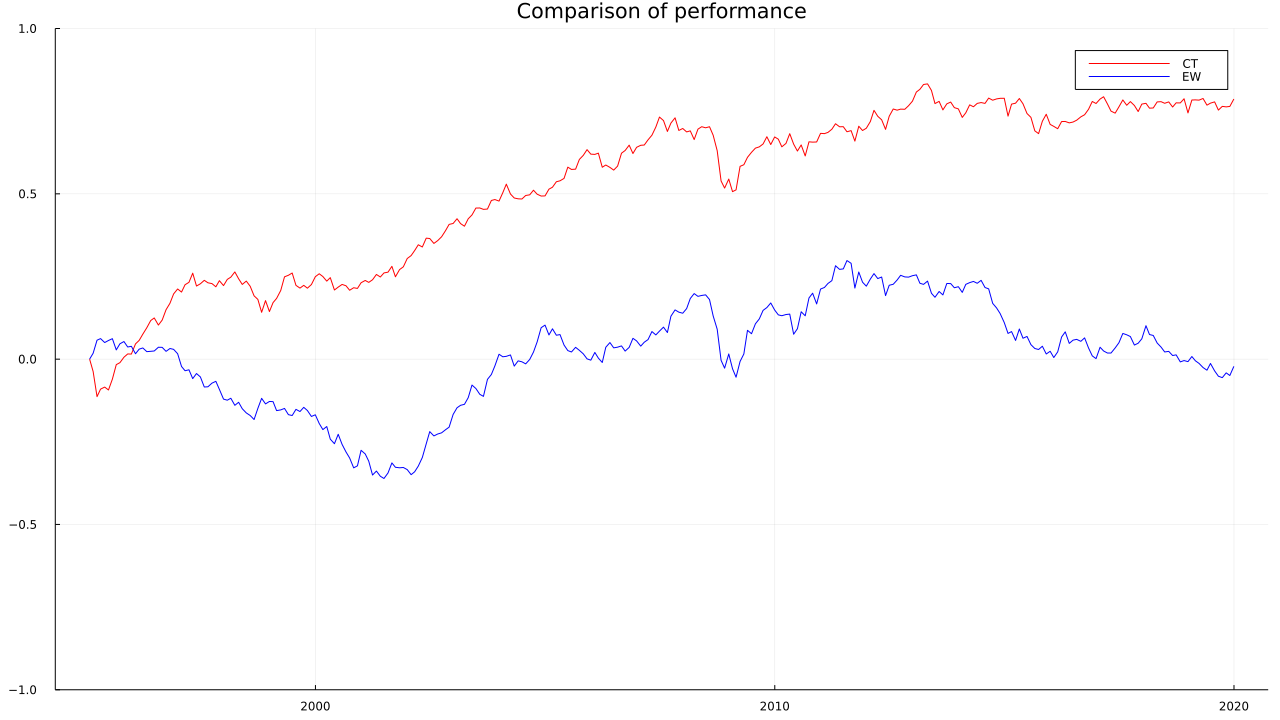

In [18]:
# Remove date from matrix
fpNoDates = fp[:,2:10]
RNoDates = R[:,2:10]

(T, n) = size(fpNoDates)

#number of high/low positions 
m = 4                

# Create empty array
R_1 = fill(NaN,T)
EW = fill(NaN,T)
Frequency = fill(0, (1, n))

#loop over periods
for t = 2:T   
    s                  = sortperm(fpNoDates[t-1,:])
    w                  = zeros(n)
    # Set portfolio weight to -1/4 for the lowest 4 forward premia
    w[s[1:m]]         .= -1/m
    # Set portfolio weight to 1/4 for the highest 4 forward premia
    w[s[end-m+1:end]] .= 1/m
    # Calculate weighted portfolio returns
    R_1[t]             = w'RNoDates[t,:]
    # Calculate EW portfolio returns
    EW[t]              = fill(1/n, n)'RNoDates[t,:]
    # Calculate frequency of currencies for the highest 4 forward premia
    Frequency[s[end-m+1:end]] .+= 1
end

# Replace NaN with 0
R_1[isnan.(R_1)] .= 0
EW[isnan.(EW)] .= 0

plot(dates, [cumsum(log.(1 .+ R_1./100)) cumsum(log.(1 .+ EW./100))], 
                size = (1280, 720),
                ylim = (-1, 1),
                xticks = ([Date(2000),Date(2010),Date(2020)], ["2000","2010","2020"]),
                label = ["CT" "EW"],
                title = "Comparison of performance",
                color = ["red" "blue"]
           )


# Report some return statistics

1. For each of the two portfolio returns, report the average returns, standard deviation and their ratio (the "Sharpe ratio").

2. For each currency, report the frequency of periods that the currency is in the "high" carry trade portfolio.

In [19]:
# Calculate avg, std, sr
R_all = [R_1[2:end] EW[2:end]]

μ  = mean(R_all,dims=1)
σ  = std(R_all,dims=1)
SR = μ./σ

println("1.")
printmat([μ;σ;SR],colNames=["CT","EW"],rowNames=["avg return","std","SR"])

println("2. frequency of periods in high carry trade portfolio")
printmat(Frequency[:] ,colNames=["amount"],rowNames=["AUD","CAD","EUR","JPY","NZD","NOK","SEK","CHF","GBP"])

1.
                  CT        EW
avg return     0.284     0.018
std            2.042     2.259
SR             0.139     0.008

2. frequency of periods in high carry trade portfolio
       amount
AUD   295    
CAD   140    
EUR     7    
JPY     0    
NZD   287    
NOK   213    
SEK    95    
CHF     0    
GBP   159    

